We study the behavior of the OV circuits of the top dontsay heads.

### Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [27]:
import functools
import collections

import circuitsvis.attention as cv_attention
import circuitsvis.tokens as cv_tokens
import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import torch
import tqdm.auto as tqdm
import transformer_lens.utils as tl_utils
from fancy_einsum import einsum
from jaxtyping import Float
from tqdm.auto import tqdm
from transformer_lens import ActivationCache, HookedTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer
import dask.array

from pii import ablation, prompt_data, utils, datasets, vocab, decomp

### Load model

In [4]:
# You will need to login to huggingface first:
#   huggingface-cli login
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
hf_model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16,
)

tl_model = HookedTransformer.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    hf_model=hf_model,
    device="cuda",
    move_to_device=True,
    fold_ln=False,
    fold_value_biases=False,
    center_writing_weights=False,
    center_unembed=False,
    tokenizer=tokenizer,
    torch_dtype=torch.float16,
)

with torch.no_grad():
    print(
        tl_model.generate(
            "The capital of Germany is", max_new_tokens=20, temperature=0
        )
    )

    _, tmp_cache = tl_model.run_with_cache("hi")
    LABELS = np.array(
        decomp.get_all_resid_components(
            tl_model=tl_model, cache=tmp_cache, pos=-1, batch_idx=0
        ).labels
    )
    print(LABELS[:5])

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using pad_token, but it is not set yet.


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


  0%|          | 0/20 [00:00<?, ?it/s]

The capital of Germany is Berlin. Berlin is the largest city in Germany and is known for its rich history, cultural attractions
['EMBED' 'L0H0ATN' 'L0H1ATN' 'L0H2ATN' 'L0H3ATN']


### Load data

In [5]:
df = pd.read_pickle(
    utils.get_repo_root() / "data" / "counterfact_processed.pkl"
)
df.keys()

Index(['case_id', 'pararel_idx', 'relation_id', 'subject', 'target_new_str',
       'target_true_str', 'fact_prefix', 'irrelevant_word', 'prompt_c',
       'prompt_nc0', 'prompt_nc1', 'p_correct_c', 'p_correct_nc0',
       'p_correct_nc1', 'lo_correct_c', 'lo_correct_nc0', 'lo_correct_nc1',
       'log_bf0', 'log_bf1', 'lo_correct_c_nc0', 'lo_correct_c_nc1',
       'lo_correct_nc0_c', 'lo_correct_nc1_c', 'lo_correct_c_nc0_dcum',
       'lo_correct_c_nc1_dcum', 'lo_correct_nc0_c_dcum',
       'lo_correct_nc1_c_dcum', 'lo_correct_c_nc0_cum', 'lo_correct_c_nc1_cum',
       'lo_correct_nc0_c_cum', 'lo_correct_nc1_c_cum'],
      dtype='object')

In [96]:
log_bf_nc_c = np.concatenate(
    [
        np.stack(df.lo_correct_nc0_c) - df.lo_correct_nc0.to_numpy()[:, None],
        np.stack(df.lo_correct_nc1_c) - df.lo_correct_nc0.to_numpy()[:, None],
    ]
)
log_bf_c_nc = np.concatenate(
    [
        np.stack(df.lo_correct_c_nc0) - df.lo_correct_nc0.to_numpy()[:, None],
        np.stack(df.lo_correct_c_nc1) - df.lo_correct_nc0.to_numpy()[:, None],
    ]
)
print(log_bf_c_nc.shape, log_bf_nc_c.shape)

COMPONENT_ORDER = np.argsort(log_bf_nc_c.mean(axis=0))
LABELS_ORDERED = LABELS[COMPONENT_ORDER]
print(LABELS_ORDERED[:5])

(6152, 1057) (6152, 1057)
['L18H9ATN' 'L27H29ATN' 'L31MLP' 'L26H9ATN' 'L25MLP']


### Analyze OV circuits

In [110]:
def get_ov_resp_matrix(layer: int, head: int):
    """Returns a matrix in units of log_e-prob."""
    W_O = tl_model.W_O[layer, head]
    W_V = tl_model.W_V[layer, head]

    with torch.no_grad():
        return utils.unembed(
            tl_model.W_E @ W_V @ W_O, tl_model=tl_model
        ).log_softmax(dim=-1)


def plot_ov_resp_matrix(
    layer: int,
    head: int,
    top_tokens: int = 3,
):
    resp_mat = get_ov_resp_matrix(layer=layer, head=head)
    log10_resp_diag = resp_mat.diag().cpu().numpy() / np.log(10)
    log10_resp_offdiag = resp_mat.flatten()[
        ~torch.eye(n=resp_mat.shape[0], dtype=torch.bool).flatten()
    ] / np.log(10)
    del resp_mat

    # utils.print_most_likely_tokens(
    #     log10_resp_diag,
    #     tl_model,
    #     n_tokens=viz_tokens,
    #     largest=False,
    # )

    top_tokens = torch.topk(
        torch.tensor(log10_resp_diag).float(), top_tokens, largest=False
    ).indices

    log10_bf = log_bf_nc_c.mean(axis=0)[
        list(LABELS).index(f"L{layer}H{head}ATN")
    ]
    plt.text(
        0.05,
        0.95,
        "\n".join(
            [
                f"L{layer}H{head}",
                f"$\log_{{10}}$ B.f.: {log10_bf:.3f}",
                "Top tokens:",
            ]
            + [
                f"{tl_model.to_string(tok.item())} ({log10_resp_diag[tok.item()]:.3f})"
                for tok in top_tokens
            ]
        ),
        horizontalalignment="left",
        verticalalignment="top",
        transform=plt.gca().transAxes,
    )

    plt.hist(
        log10_resp_diag, bins=128, density=True, alpha=0.5, label="Diagonal"
    )
    utils.plot_hist_from_tensor(
        log10_resp_offdiag,
        bins=256,
        density=True,
        alpha=0.5,
        label="Off-diagonal",
        color="tab:orange",
    )
    plt.axvline(
        np.log10(1 / tl_model.cfg.d_vocab),
        color="black",
        linestyle="dotted",
        label="$\log_{10}$(1 / d_vocab)",
    )

  0%|          | 0/9 [00:00<?, ?it/s]

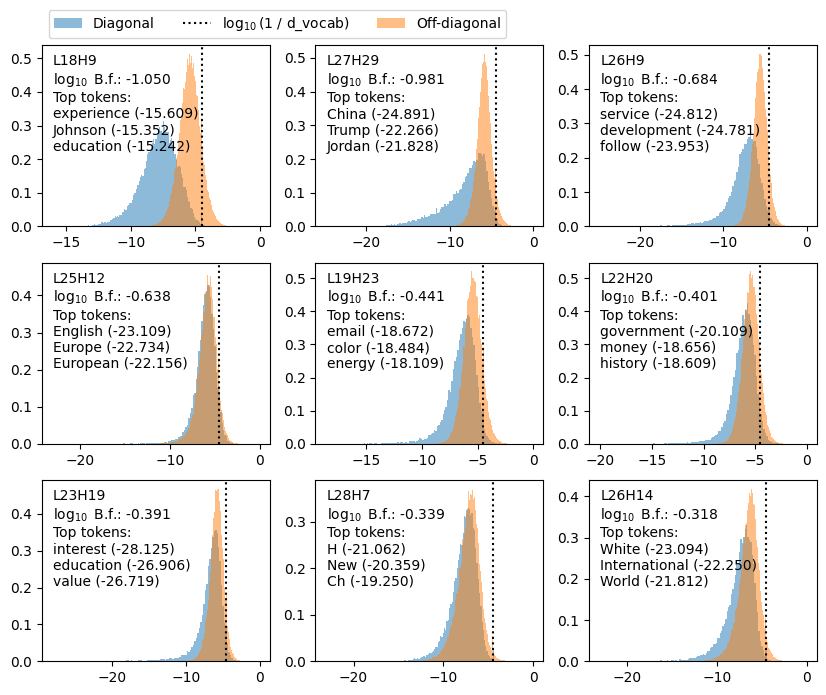

In [112]:
atn_head_locs = [
    (int(label.split("H")[0][1:]), int(label.split("H")[1][:-3]))
    for label in LABELS_ORDERED
    if "ATN" in label
]

plt.figure(figsize=(10, 8))
for i in tqdm(range(9)):
    plt.subplot(3, 3, i + 1)

    layer, head = atn_head_locs[i]
    plot_ov_resp_matrix(layer=layer, head=head, top_tokens=3)
    if i == 0:
        plt.legend(bbox_to_anchor=(0, 1), loc="lower left", ncol=3)

  0%|          | 0/9 [00:00<?, ?it/s]

/home/mier/.local/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Glyph 20107 (\N{CJK UNIFIED IDEOGRAPH-4E8B}) missing from current font.
  func(*args, **kwargs)
/home/mier/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20107 (\N{CJK UNIFIED IDEOGRAPH-4E8B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


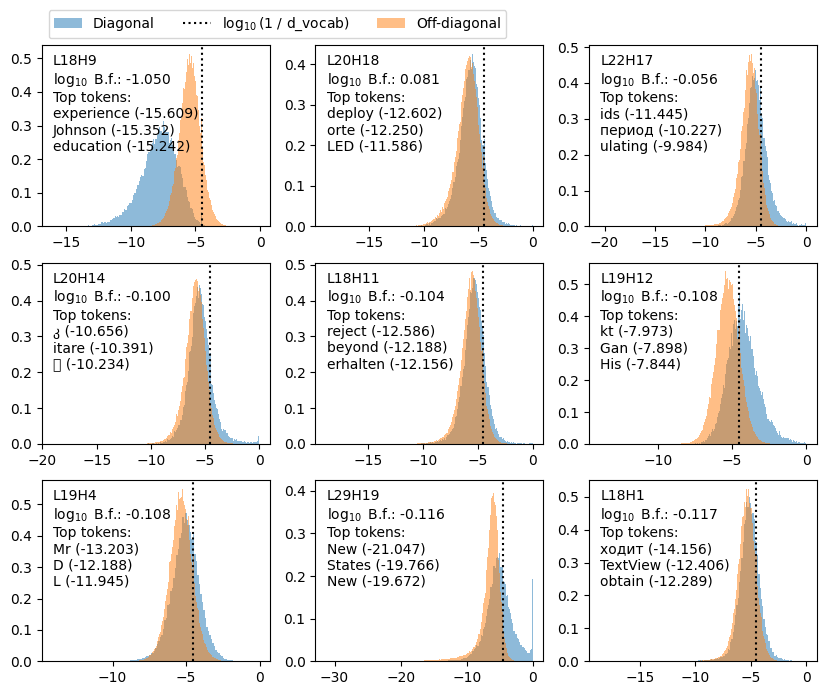

In [113]:
atn_head_locs = [
    (int(label.split("H")[0][1:]), int(label.split("H")[1][:-3]))
    for label in LABELS_ORDERED
    if "ATN" in label
]

plt.figure(figsize=(10, 8))
for i in tqdm(range(9)):
    plt.subplot(3, 3, i + 1)

    layer, head = atn_head_locs[-i - 1]
    plot_ov_resp_matrix(layer=layer, head=head, top_tokens=3)
    if i == 0:
        plt.legend(bbox_to_anchor=(0, 1), loc="lower left", ncol=3)